In [98]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import os
import json
import requests
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import string
import mapclassify
from shapely.ops import unary_union
plt.style.use('ggplot')


# Opening GeoJSONs and exploring data

### Zoning data

In [130]:
zones_geodata = gpd.read_file('CME538_Daniel_Group_Zoning Area - 4326.geojson')
zones_geodata = zones_geodata.set_index(zones_geodata.columns[0])
zones_geodata.head()

,GEN_ZONE,ZN_ZONE,ZN_HOLDING,HOLDING_ID,FRONTAGE,ZN_AREA,UNITS,DENSITY,COVERAGE,FSI_TOTAL,...,ZN_EXCPTN,EXCPTN_NO,STAND_SET,ZN_STATUS,ZN_STRING,AREA_UNITS,ZBL_CHAPT,ZBL_SECTN,ZBL_EXCPTN,geometry
_id,,,,,,,,,,,,,,,,,,,,,
1,2,UT,N,0,-1.0,-1,-1,-1.0,0.0,-1.0,...,N,0,-1,2,UT,-1.0,100,100.10,,"MULTIPOLYGON (((-79.20970 43.81729, -79.20961 ..."
2,1,ON,N,0,-1.0,-1,-1,-1.0,0.0,-1.0,...,N,0,-1,0,ON,-1.0,90,90.20,,"MULTIPOLYGON (((-79.50273 43.70976, -79.50195 ..."
3,0,RD,N,0,14.0,510,0,0.0,0.0,-1.0,...,Y,1058,-1,2,RD (f14.0; a510) (x1058),0.0,10,10.20,900.3.10(1058),"MULTIPOLYGON (((-79.27433 43.80068, -79.27425 ..."
4,1,O,N,0,-1.0,-1,-1,-1.0,0.0,-1.0,...,N,0,-1,3,O,-1.0,90,90.10,,"MULTIPOLYGON (((-79.57040 43.72175, -79.57042 ..."
5,0,RD,N,0,0.0,0,0,0.0,0.0,-1.0,...,Y,1040,-1,2,RD (x1040),0.0,10,10.20,900.3.10(1040),"MULTIPOLYGON (((-79.26202 43.81195, -79.26214 ..."


From the description of data: 

**ZN_ZONE**

The land use category of the lands within the zone boundary. Each 'zone category' has its own Chapter in the text of By-law 569-2013. Zoned destination of the zone limited by GEN_ZONE. 
- 0 = Residential 
- 1 = Open Space 
- 2 = Utility and Transportation 
- 4 = Employment Industrial 
- 5 = Institutional 
- 6 = Commercial Residential Employment 
- 101 = Residential Apartment 
- 201 = Commercial 
- 202 = Commercial Residential

In [126]:
zones_geodata.GEN_ZONE.unique()

array([  2,   1,   0,   4, 201, 202, 101,   6,   5])

In [134]:
# Only keep zoning type, and geometry, rest is not relevant
zones_geodata_cleaned = zones_geodata[['GEN_ZONE', 'geometry']]

# Rename 'GEN_ZONE' to 'Zone_type'
zones_geodata_cleaned.rename(columns={'GEN_ZONE': 'Zone_type'}, inplace=True)

# Define the mapping for Zone Type values
zone_mapping = {0: 'Residential', 1: 'Open Space', 2: 'Utility and Transportation', 
                4: 'Employment Industrial', 5: 'Institutional',
                6: 'Commercial Residential Employment', 101: 'Residential Apartment', 
                201: 'Commercial', 202: 'Commercial Residential'}

# Replace the values in 'Zone_type' column with the mapped names
zones_geodata_cleaned['Zone_type'] = zones_geodata_cleaned['Zone_type'].replace(zone_mapping)

# Display the first few rows to ensure it worked
zones_geodata_cleaned.head()


/tmp/ipykernel_53/1307462323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zones_geodata_cleaned.rename(columns={'GEN_ZONE': 'Zone_type'}, inplace=True)
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Zone_type,geometry
_id,,
1,Utility and Transportation,"MULTIPOLYGON (((-79.20970 43.81729, -79.20961 ..."
2,Open Space,"MULTIPOLYGON (((-79.50273 43.70976, -79.50195 ..."
3,Residential,"MULTIPOLYGON (((-79.27433 43.80068, -79.27425 ..."
4,Open Space,"MULTIPOLYGON (((-79.57040 43.72175, -79.57042 ..."
5,Residential,"MULTIPOLYGON (((-79.26202 43.81195, -79.26214 ..."


In [158]:
zones_geodata_cleaned.crs #check crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

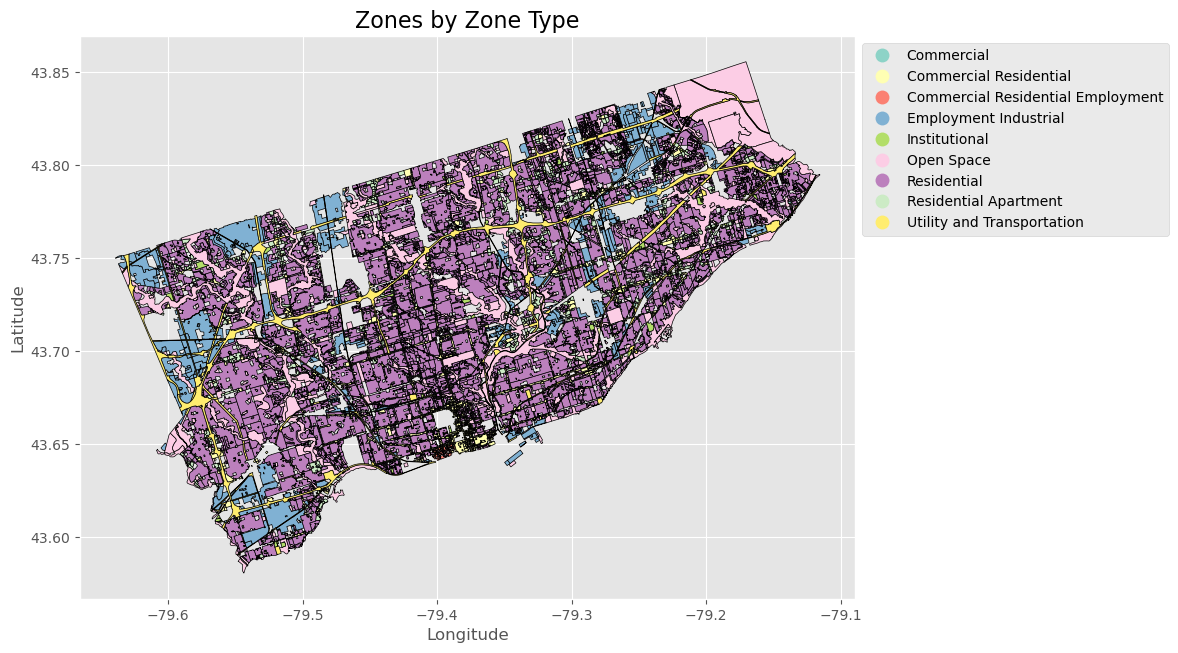

In [151]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot with categorical coloring based on 'Zone_type'
zones_geodata_cleaned.plot(column='Zone_type', ax=ax, legend=True, 
                           legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'}, 
                           cmap='Set3', edgecolor='black')

# Add labels
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add title
plt.title('Zones by Zone Type', fontsize=16)

# Display the plot
plt.show()

### Greenspace data

In [144]:
greenspace = gpd.read_file('Green Spaces - 4326.geojson')
greenspace = greenspace.set_index(greenspace.columns[0])
greenspace.head()

,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_CLASS_ID,AREA_CLASS,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,OBJECTID,geometry
_id,,,,,,,,,,,
1,1,1,0,890.0,OTHER_CEMETERY,None,4009,ARMADALE FREE METHODIST CEMETERY,ARMADALE FREE METHODIST CEMETERY,1.0,"MULTIPOLYGON (((-79.25752 43.82953, -79.25739 ..."
2,2,2,0,890.0,OTHER_CEMETERY,None,4010,HILLSIDE CEMETERY,HILLSIDE CEMETERY,2.0,"MULTIPOLYGON (((-79.18962 43.82488, -79.18949 ..."
3,3,3,0,890.0,OTHER_CEMETERY,None,4011,HIGHLAND MEMORY GARDENS,HIGHLAND MEMORY GARDENS,3.0,"MULTIPOLYGON (((-79.34758 43.80810, -79.34758 ..."
4,4,4,0,890.0,OTHER_CEMETERY,None,4005,CHRISTIE'S METHODIST CEMETERY,CHRISTIE'S METHODIST CEMETERY,4.0,"MULTIPOLYGON (((-79.31835 43.79902, -79.31851 ..."
5,5,5,0,890.0,OTHER_CEMETERY,None,4012,ST. PAUL'S ANGLICAN CHURCH CEMETERY,ST. PAUL'S ANGLICAN CHURCH CEMETERY,5.0,"MULTIPOLYGON (((-79.31649 43.79640, -79.31650 ..."


In [141]:
greenspace.columns.unique()

Index(['AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_CLASS_ID',
       'AREA_CLASS', 'AREA_SHORT_CODE', 'AREA_LONG_CODE', 'AREA_NAME',
       'AREA_DESC', 'OBJECTID', 'geometry'],
      dtype='object')

In [145]:
greenspace_cleaned = greenspace[['AREA_CLASS', 'geometry']]
greenspace_cleaned.rename(columns={'AREA_CLASS': 'Area_type'}, inplace=True)
greenspace_cleaned.head()


/tmp/ipykernel_53/3715004460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  greenspace_cleaned.rename(columns={'AREA_CLASS': 'Area_type'}, inplace=True)


,Area_type,geometry
_id,,
1,OTHER_CEMETERY,"MULTIPOLYGON (((-79.25752 43.82953, -79.25739 ..."
2,OTHER_CEMETERY,"MULTIPOLYGON (((-79.18962 43.82488, -79.18949 ..."
3,OTHER_CEMETERY,"MULTIPOLYGON (((-79.34758 43.80810, -79.34758 ..."
4,OTHER_CEMETERY,"MULTIPOLYGON (((-79.31835 43.79902, -79.31851 ..."
5,OTHER_CEMETERY,"MULTIPOLYGON (((-79.31649 43.79640, -79.31650 ..."


In [157]:
greenspace_cleaned.crs #check crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

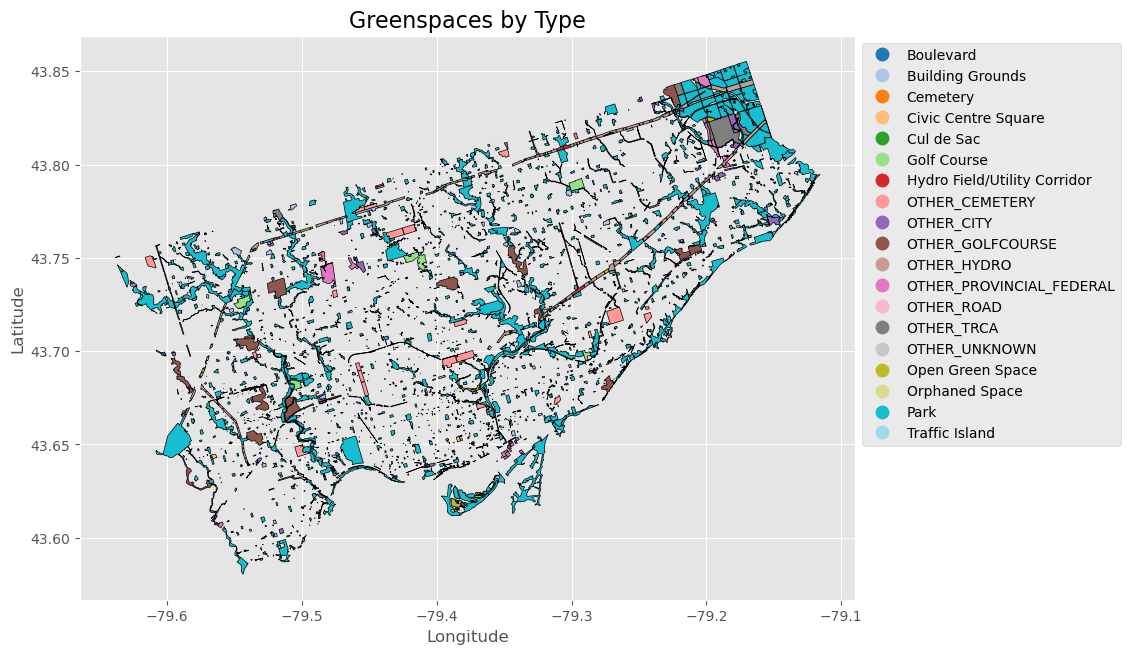

In [148]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot with categorical coloring based on 'Zone_type'
greenspace_cleaned.plot(column='Area_type', ax=ax, legend=True, 
                           legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'}, 
                           cmap='tab20', edgecolor='black')

# Add labels
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add title
plt.title('Greenspaces by Type', fontsize=16)

# Display the plot
plt.show()

### Flood plains data

In [123]:
flood_plains = gpd.read_file('Floodline GeoJson Format.geojson')
flood_plains = flood_plains.set_index(flood_plains.columns[0])
flood_plains.head()


,FloodPlain,Watershed,Shape__Are,Shape__Len,geometry
OBJECTID,,,,,
3394,Engineered,Don River,0.940918,3.803569,"MULTIPOLYGON (((-79.36482 43.67112, -79.36482 ..."
3395,Engineered,Don River,869.856689,149.201240,"MULTIPOLYGON (((-79.38004 43.67332, -79.38004 ..."
3396,Engineered,Don River,23187.910400,1321.226703,"MULTIPOLYGON (((-79.37672 43.67350, -79.37671 ..."
3397,Engineered,Don River,10895.613037,522.001575,"MULTIPOLYGON (((-79.37840 43.67362, -79.37840 ..."
3406,Engineered,Humber River,0.544922,5.605709,"MULTIPOLYGON (((-79.50360 43.71073, -79.50360 ..."


In [156]:
flood_plains.crs #check crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

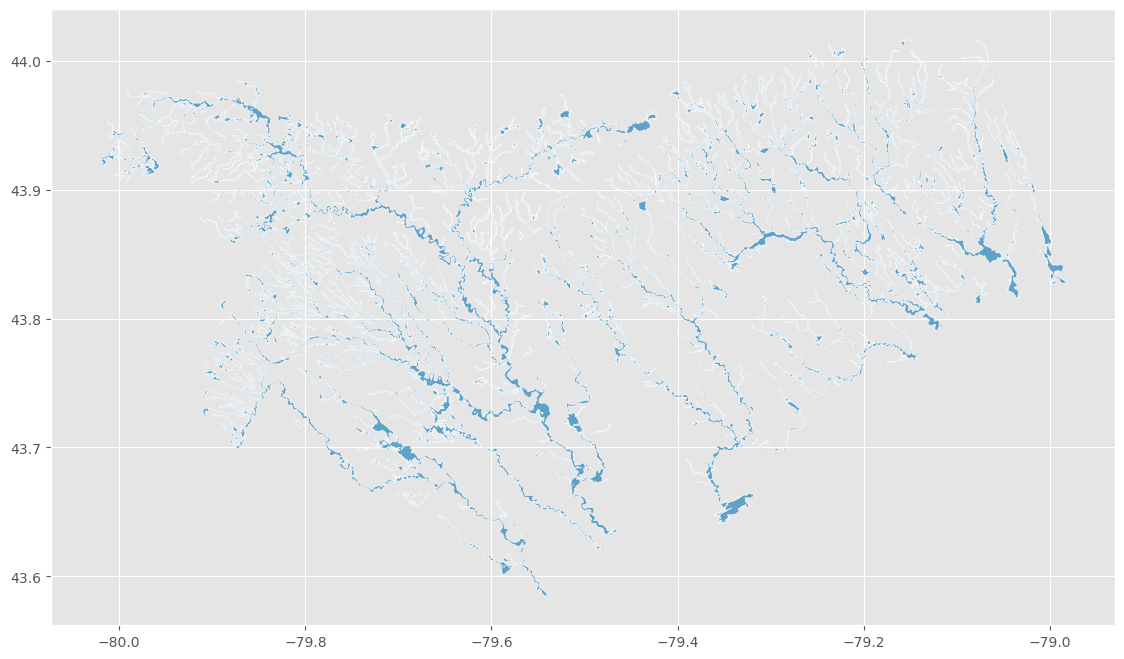

In [112]:
# Test plotting
flood_plains.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

### Neighbourhood data

In [70]:
neighbourhoods_geodata = gpd.read_file('Neighbourhoods - 4326.geojson')
neighbourhoods_geodata.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,CLASSIFICATION,CLASSIFICATION_CODE,OBJECTID,geometry
0,1,2502366,26022881,0,174,174,South Eglinton-Davisville,South Eglinton-Davisville (174),Not an NIA or Emerging Neighbourhood,NA,17824737.0,"MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ..."
1,2,2502365,26022880,0,173,173,North Toronto,North Toronto (173),Not an NIA or Emerging Neighbourhood,NA,17824753.0,"MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ..."
2,3,2502364,26022879,0,172,172,Dovercourt Village,Dovercourt Village (172),Not an NIA or Emerging Neighbourhood,NA,17824769.0,"MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ..."
3,4,2502363,26022878,0,171,171,Junction-Wallace Emerson,Junction-Wallace Emerson (171),Not an NIA or Emerging Neighbourhood,NA,17824785.0,"MULTIPOLYGON (((-79.43870 43.66766, -79.43841 ..."
4,5,2502362,26022877,0,170,170,Yonge-Bay Corridor,Yonge-Bay Corridor (170),Not an NIA or Emerging Neighbourhood,NA,17824801.0,"MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ..."


In [72]:
keep_columns = ['AREA_NAME', 'geometry']                                                #define columns to keep
neighbourhoods_geodata = neighbourhoods_geodata.filter(items=keep_columns)                            #filter df by columns
neighbourhoods_geodata.columns = ['Neighbourhood Name', 'geometry']                                         #rename columns
neighbourhoods_geodata = neighbourhoods_geodata.set_index(neighbourhoods_geodata.columns[0])

# View GeoDataFrame
neighbourhoods_geodata.head()

,geometry
Neighbourhood Name,
South Eglinton-Davisville,"MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ..."
North Toronto,"MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ..."
Dovercourt Village,"MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ..."
Junction-Wallace Emerson,"MULTIPOLYGON (((-79.43870 43.66766, -79.43841 ..."
Yonge-Bay Corridor,"MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ..."


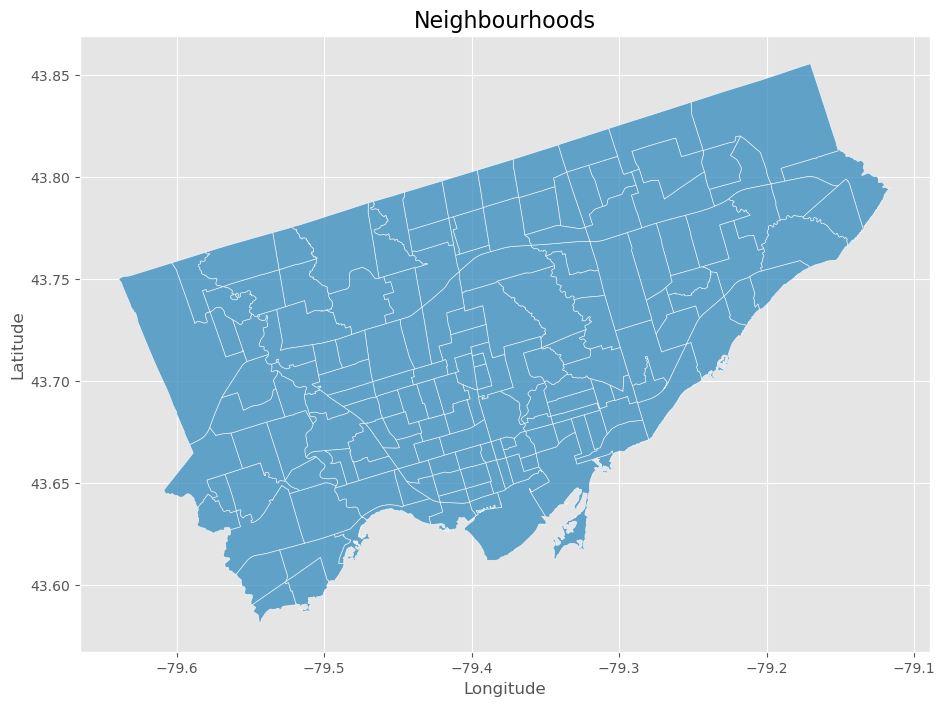

In [150]:
neighbourhoods_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add title
plt.title('Neighbourhoods', fontsize=16)

# Display the plot
plt.show()

### Demographics Data

In [73]:
pip install pandas openpyxl


Note: you may need to restart the kernel to use updated packages.


In [74]:
# Read the .xlsx file into a pandas DataFrame
neighbourhood_demographics = pd.read_excel("neighbourhood-profiles-2021-158-model.xlsx", engine="openpyxl")

# Print the DataFrame
neighbourhood_demographics.head()

,Neighbourhood Name,West Humber-Clairville,Mount Olive-Silverstone-Jamestown,Thistletown-Beaumond Heights,Rexdale-Kipling,Elms-Old Rexdale,Kingsview Village-The Westway,Willowridge-Martingrove-Richview,Humber Heights-Westmount,Edenbridge-Humber Valley,...,Harbourfront-CityPlace,St Lawrence-East Bayfront-The Islands,Church-Wellesley,Downtown Yonge East,Bay-Cloverhill,Yonge-Bay Corridor,Junction-Wallace Emerson,Dovercourt Village,North Toronto,South Eglinton-Davisville
0,Neighbourhood Number,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
1,TSNS 2020 Designation,Not an NIA or Emerging Neighbourhood,Neighbourhood Improvement Area,Neighbourhood Improvement Area,Not an NIA or Emerging Neighbourhood,Neighbourhood Improvement Area,Neighbourhood Improvement Area,Not an NIA or Emerging Neighbourhood,Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,...,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood
2,Total - Age groups of the population - 25% sam...,33300,31345,9850,10375,9355,22005,22445,10005,15190,...,28135,31285,22320,17700,16670,12645,23180,12380,15885,22735
3,0 to 14 years,4295,5690,1495,1575,1610,3915,3500,1370,2070,...,2065,2285,895,1055,745,970,3075,1365,1315,2190
4,0 to 4 years,1460,1650,505,505,440,1245,1065,395,520,...,1030,1045,495,480,370,500,1135,445,535,910


In [75]:
neighbourhood_demographics = neighbourhood_demographics.set_index(neighbourhood_demographics.columns[0])
neighbourhood_demographics.head()

,West Humber-Clairville,Mount Olive-Silverstone-Jamestown,Thistletown-Beaumond Heights,Rexdale-Kipling,Elms-Old Rexdale,Kingsview Village-The Westway,Willowridge-Martingrove-Richview,Humber Heights-Westmount,Edenbridge-Humber Valley,Princess-Rosethorn,...,Harbourfront-CityPlace,St Lawrence-East Bayfront-The Islands,Church-Wellesley,Downtown Yonge East,Bay-Cloverhill,Yonge-Bay Corridor,Junction-Wallace Emerson,Dovercourt Village,North Toronto,South Eglinton-Davisville
Neighbourhood Name,,,,,,,,,,,,,,,,,,,,,
Neighbourhood Number,1,2,3,4,5,6,7,8,9,10,...,165,166,167,168,169,170,171,172,173,174
TSNS 2020 Designation,Not an NIA or Emerging Neighbourhood,Neighbourhood Improvement Area,Neighbourhood Improvement Area,Not an NIA or Emerging Neighbourhood,Neighbourhood Improvement Area,Neighbourhood Improvement Area,Not an NIA or Emerging Neighbourhood,Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,...,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood
Total - Age groups of the population - 25% sample data,33300,31345,9850,10375,9355,22005,22445,10005,15190,11170,...,28135,31285,22320,17700,16670,12645,23180,12380,15885,22735
0 to 14 years,4295,5690,1495,1575,1610,3915,3500,1370,2070,1750,...,2065,2285,895,1055,745,970,3075,1365,1315,2190
0 to 4 years,1460,1650,505,505,440,1245,1065,395,520,545,...,1030,1045,495,480,370,500,1135,445,535,910


In [76]:
len(neighbourhood_demographics.columns.tolist())


158

In [77]:
neighbourhood_demographics_transpose = neighbourhood_demographics.T
neighbourhood_demographics_transpose.head()

Neighbourhood Name,Neighbourhood Number,TSNS 2020 Designation,Total - Age groups of the population - 25% sample data,0 to 14 years,0 to 4 years,5 to 9 years,10 to 14 years,15 to 64 years,15 to 19 years,20 to 24 years,...,Between 9 a.m. and 11:59 a.m.,Between 12 p.m. and 4:59 a.m.,Total - Eligibility for instruction in the minority official language for the population in private households born in 2003 or later - 25% sample data,Children eligible for instruction in the minority official language,Children not eligible for instruction in the minority official language,"Total - Eligibility and instruction in the minority official language, for the population in private households born between 2003 and 2015 (inclusive) - 25% sample data",Children eligible for instruction in the minority official language,Eligible children who have been instructed in the minority official language at the primary or secondary level in Canada,Eligible children who have not been instructed in the minority official language at the primary or secondary level in Canada,Children not eligible for instruction in the minority official language
West Humber-Clairville,1,Not an NIA or Emerging Neighbourhood,33300,4295,1460,1345,1485,23640,1860,3175,...,1665,2935,5430,410,5020,3875,335,255,75,3540
Mount Olive-Silverstone-Jamestown,2,Neighbourhood Improvement Area,31345,5690,1650,1860,2175,21490,2280,2675,...,1145,2965,7285,510,6780,5540,395,245,145,5145
Thistletown-Beaumond Heights,3,Neighbourhood Improvement Area,9850,1495,505,540,455,6615,570,745,...,395,635,1860,180,1685,1325,120,75,45,1205
Rexdale-Kipling,4,Not an NIA or Emerging Neighbourhood,10375,1575,505,615,455,6950,515,715,...,425,775,1910,135,1770,1370,90,75,25,1275
Elms-Old Rexdale,5,Neighbourhood Improvement Area,9355,1610,440,480,685,6355,635,685,...,355,675,2015,95,1920,1520,70,60,10,1445


In [78]:
neighbourhood_demographics_transpose.shape

(158, 2603)

### Combining datasets 

In [79]:
merged_neighbourhood_df = pd.merge(neighbourhood_demographics_transpose, neighbourhoods_geodata, left_index=True, right_index=True, how='inner')
merged_neighbourhood_df.head()

,Neighbourhood Number,TSNS 2020 Designation,Total - Age groups of the population - 25% sample data,0 to 14 years,0 to 4 years,5 to 9 years,10 to 14 years,15 to 64 years,15 to 19 years,20 to 24 years,...,Between 12 p.m. and 4:59 a.m.,Total - Eligibility for instruction in the minority official language for the population in private households born in 2003 or later - 25% sample data,Children eligible for instruction in the minority official language,Children not eligible for instruction in the minority official language,"Total - Eligibility and instruction in the minority official language, for the population in private households born between 2003 and 2015 (inclusive) - 25% sample data",Children eligible for instruction in the minority official language,Eligible children who have been instructed in the minority official language at the primary or secondary level in Canada,Eligible children who have not been instructed in the minority official language at the primary or secondary level in Canada,Children not eligible for instruction in the minority official language,geometry
West Humber-Clairville,1,Not an NIA or Emerging Neighbourhood,33300,4295,1460,1345,1485,23640,1860,3175,...,2935,5430,410,5020,3875,335,255,75,3540,"MULTIPOLYGON (((-79.59037 43.73401, -79.58942 ..."
Mount Olive-Silverstone-Jamestown,2,Neighbourhood Improvement Area,31345,5690,1650,1860,2175,21490,2280,2675,...,2965,7285,510,6780,5540,395,245,145,5145,"MULTIPOLYGON (((-79.57938 43.76222, -79.57925 ..."
Thistletown-Beaumond Heights,3,Neighbourhood Improvement Area,9850,1495,505,540,455,6615,570,745,...,635,1860,180,1685,1325,120,75,45,1205,"MULTIPOLYGON (((-79.56226 43.74373, -79.56234 ..."
Rexdale-Kipling,4,Not an NIA or Emerging Neighbourhood,10375,1575,505,615,455,6950,515,715,...,775,1910,135,1770,1370,90,75,25,1275,"MULTIPOLYGON (((-79.56419 43.71229, -79.56670 ..."
Elms-Old Rexdale,5,Neighbourhood Improvement Area,9355,1610,440,480,685,6355,635,685,...,675,2015,95,1920,1520,70,60,10,1445,"MULTIPOLYGON (((-79.54677 43.73156, -79.54632 ..."


In [80]:
merged_neighbourhood_df.columns.tolist()

['Neighbourhood Number',
 'TSNS 2020 Designation',
 'Total - Age groups of the population - 25% sample data',
 '  0 to 14 years',
 '    0 to 4 years',
 '    5 to 9 years',
 '    10 to 14 years',
 '  15 to 64 years',
 '    15 to 19 years',
 '    20 to 24 years',
 '    25 to 29 years',
 '    30 to 34 years',
 '    35 to 39 years',
 '    40 to 44 years',
 '    45 to 49 years',
 '    50 to 54 years',
 '    55 to 59 years',
 '    60 to 64 years',
 '  65 years and over',
 '    65 to 69 years',
 '    70 to 74 years',
 '    75 to 79 years',
 '    80 to 84 years',
 '    85 years and over',
 '      85 to 89 years',
 '      90 to 94 years',
 '      95 to 99 years',
 '      100 years and over',
 'Total - Distribution (%) of the population by broad age groups - 25% sample data',
 '  0 to 14 years',
 '  15 to 64 years',
 '  65 years and over',
 '    85 years and over',
 'Average age of the population',
 'Median age of the population',
 'Total - Persons in private households - 25% sample data',
 '  T

/tmp/ipykernel_53/2862604344.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  intersection = gpd.overlay(flood_line, neighbourhoods_geodata, how='intersection')


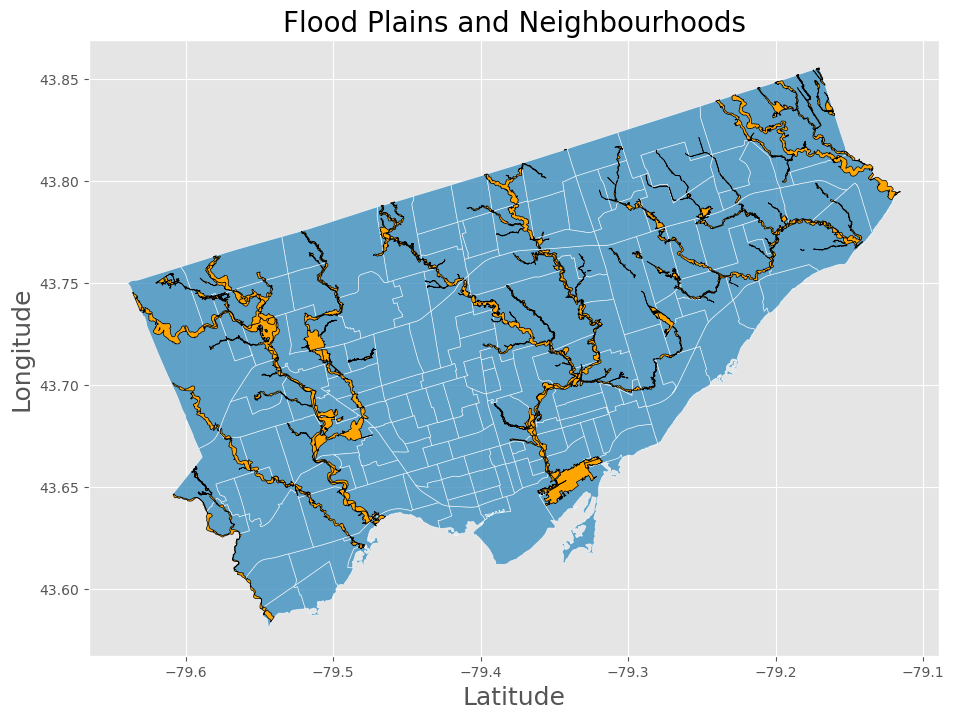

In [154]:
intersection = gpd.overlay(flood_line, neighbourhoods_geodata, how='intersection')

# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the neighbourhoods
neighbourhoods_geodata.plot(ax=ax, edgecolor='w', alpha=0.75)

# Plot the flood line only if it intersects the neighbourhoods
if not intersection.empty:
    intersection.plot(ax=ax, color='orange', edgecolor='k', label='Flood Plains Intersection')

# Labeling the axes
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)

# Add title
plt.title('Flood Plains and Neighbourhoods', fontsize=20)

# Show the plot
plt.show()

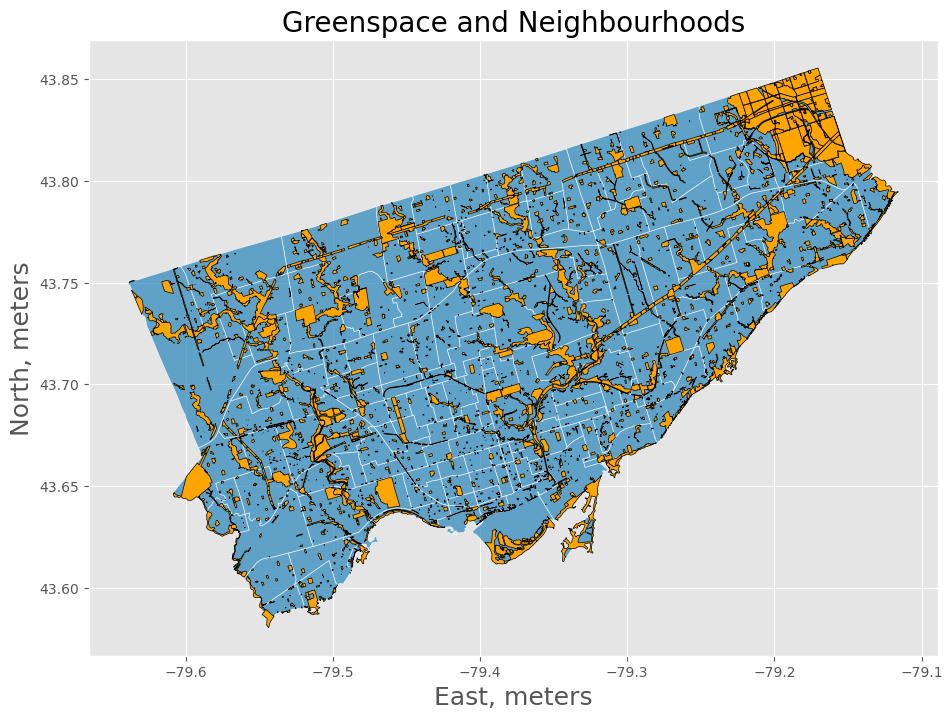

In [117]:
ax = neighbourhoods_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)                       #plot size and colour
greenspace.plot(ax=ax, color='orange', edgecolor='k', label='Flood Plains')  
plt.xlabel('East, meters', fontsize=18)                                                    #axses labels
plt.ylabel('North, meters', fontsize=18) 
plt.title('Greenspace and Neighbourhoods', fontsize=20)                          #title
plt.show()

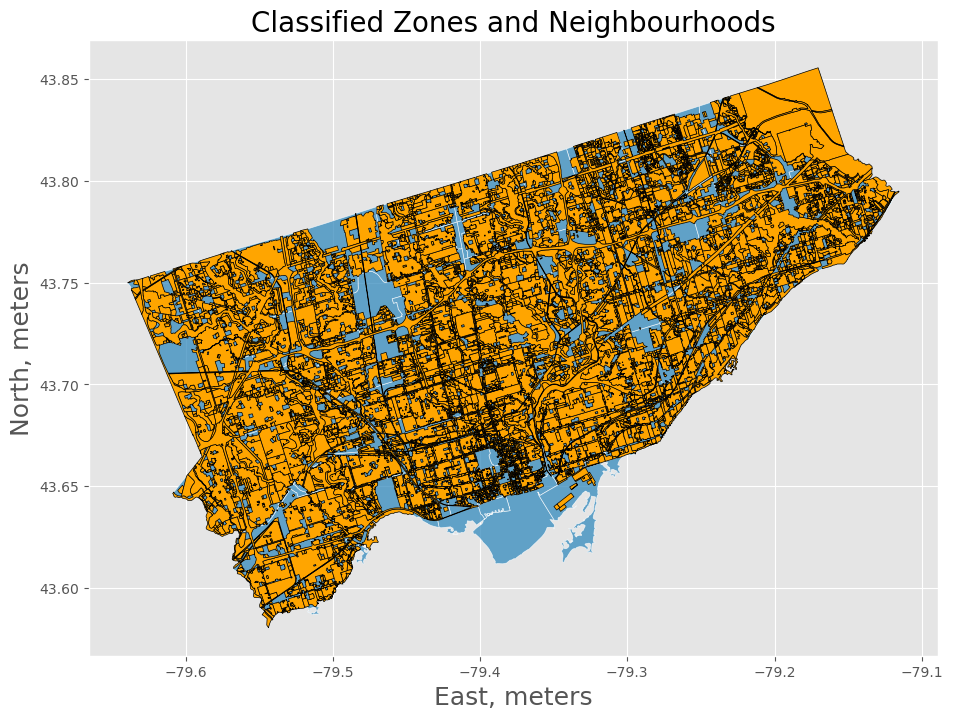

In [119]:
ax = neighbourhoods_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)                       #plot size and colour
zones_geodata.plot(ax=ax, color='orange', edgecolor='k', label='Flood Plains')  
plt.xlabel('East, meters', fontsize=18)                                                    #axses labels
plt.ylabel('North, meters', fontsize=18) 
plt.title('Classified Zones and Neighbourhoods', fontsize=20)                          #title
plt.show()

/opt/conda/lib/python3.11/site-packages/mapclassify/classifiers.py:461: RuntimeWarning: invalid value encountered in greater
  binIds += (x > _l) * (x <= r) * k
/opt/conda/lib/python3.11/site-packages/mapclassify/classifiers.py:461: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > _l) * (x <= r) * k


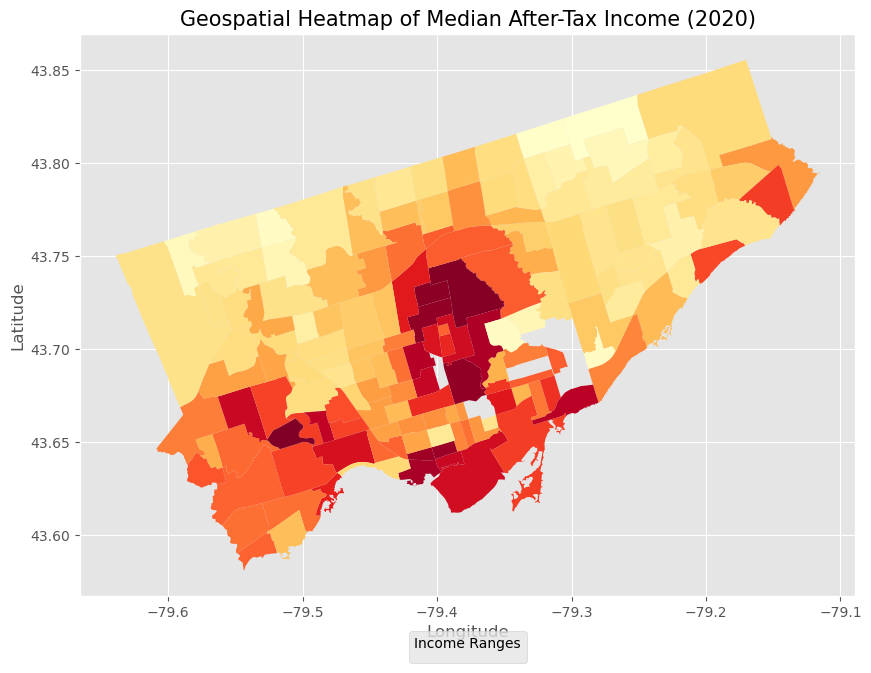

In [121]:
income_data = neighbourhood_demographics_transpose[["    Median total income in 2020  among recipients ($)"]]
merged_gdf = neighbourhoods_geodata.join(income_data)

classifier = mapclassify.Quantiles(merged_gdf["    Median total income in 2020  among recipients ($)"], k=4)
merged_gdf["income_bins"] = classifier.yb  # Add the classification to the GeoDataFrame


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with the selected income column for color mapping
merged_gdf.plot(column="    Median total income in 2020  among recipients ($)",
                ax=ax,
                cmap='YlOrRd',  # Choose the color map, e.g., 'viridis', 'coolwarm', etc.
                legend_kwds={
                    'label': "Median After-Tax Income ($)",  # Label for the legend
                    'orientation': "horizontal",  # Orientation of the legend
                    'bbox_to_anchor': (0.5, -0.05),  # Position the legend
                    'loc': 'upper center'  # Position legend in the center
                })

# Customize the legend
# Create a list of the bin labels based on the classification
bin_labels = [f"{round(classifier.bins[i], 2)} - {round(classifier.bins[i + 1], 2)}"
              for i in range(len(classifier.bins) - 1)]

# Add a legend with the appropriate bin ranges
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, bin_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, title="Income Ranges")

# Add title and labels
ax.set_title("Geospatial Heatmap of Median After-Tax Income (2020)", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()
